In [4]:
import torch # for some reason we need to do this first!


from root_pandas import read_root
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set()

In [5]:
# to use GPU
device = torch.device("cuda")
device

device(type='cuda')

In [80]:
cols=["Mpi0g1","Mpi0g2","Mpi0","Meta","Mpi0eta","mandelstam_tpi0","cosTheta_eta_gj","phi_eta_gj",
     "cosThetaHighestEphotonIneta_gj","pi0_energy","mcprocess","chiSq"]

In [81]:
data = read_root('allMC_tree_ext_subset.root', 'degALL_acc_mEllipse_tree_flat',columns=cols)

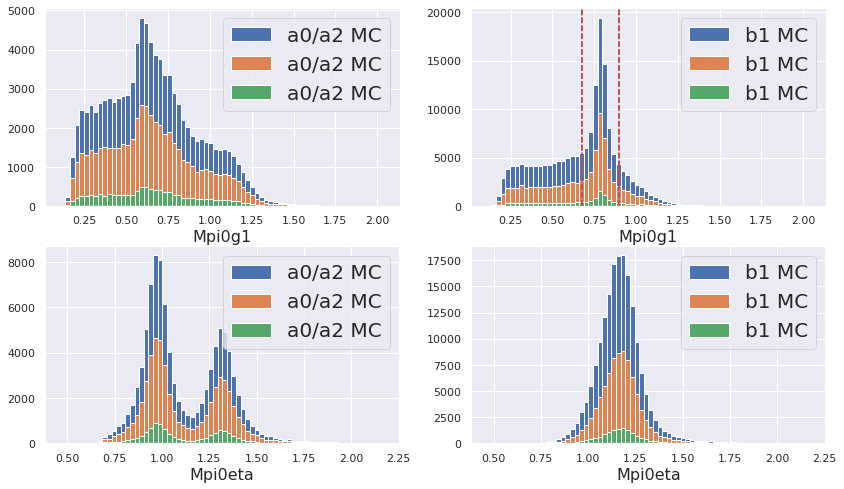

In [84]:
lowThresh=0.675
uppThresh=0.9

fig,ax=plt.subplots(2,2,figsize=(14,8))
ax=ax.flatten()

binedges1=np.histogram(df.Mpi0g1,bins=70)[1]
binedges2=np.histogram(df.Mpi0eta,bins=70)[1]
for i in [5,3,1]:
    df=data[data.chiSq<i]

    df[(df.mcprocess==0)|(df.mcprocess==1)].Mpi0g1.hist(bins=binedges1,ax=ax[0],label="a0/a2 MC")
    df[df.mcprocess==2].Mpi0g1.hist(bins=binedges1,ax=ax[1],label="b1 MC")
    ax[0].set_xlabel("Mpi0g1",size=16)
    ax[1].set_xlabel("Mpi0g1",size=16)
    ax[0].legend(prop={"size":20})
    ax[1].legend(prop={"size":20})
    ax[1].axvline(uppThresh,c='r',linestyle="--")
    ax[1].axvline(lowThresh,c='r',linestyle="--")

    # Mpi0eta
    df[(df.mcprocess==0)|(df.mcprocess==1)].Mpi0eta.hist(bins=binedges2,ax=ax[2],label="a0/a2 MC")
    df[df.mcprocess==2].Mpi0eta.hist(bins=binedges2,ax=ax[3],label="b1 MC")
    ax[2].set_xlabel("Mpi0eta",size=16)
    ax[3].set_xlabel("Mpi0eta",size=16)
    ax[2].legend(prop={"size":20})
    ax[3].legend(prop={"size":20})

In [77]:
mapProcToSigBkg={0:1,1:1,2:0,3:0,4:0,5:0,6:0}

In [68]:
selectedRegion=(data.Mpi0g1<uppThresh)&(data.Mpi0g1>lowThresh)|(data.Mpi0g2<uppThresh)&(data.Mpi0g2>lowThresh)
df=data[selectedRegion]
df.mcprocess.loc[df.mcprocess==1]=0
df.mcprocess.loc[df.mcprocess==2]=1

mcprocess=df.mcprocess
df=df.drop(["Mpi0g1","Mpi0g2","mcprocess"],axis=1)

/home/lawrence/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [10]:
mcprocess.value_counts()

1    128299
0     42386
Name: mcprocess, dtype: int64

In [75]:
data[selectedRegion]

,Mpi0g1,Mpi0g2,Mpi0,Meta,Mpi0eta,mandelstam_tpi0,cosTheta_eta_gj,phi_eta_gj,cosThetaHighestEphotonIneta_gj,pi0_energy,mcprocess
0,0.276541,0.889655,0.188334,0.473626,1.028015,0.490754,0.129920,2.039264,0.096590,4.883010,0
1,0.268572,0.853252,0.182987,0.453598,0.986122,0.460796,0.145850,2.381722,0.111239,4.731303,0
2,0.863041,0.263148,0.110732,0.594782,1.074984,0.243809,-0.512222,42.112628,0.370979,6.499741,0
3,0.263148,0.893739,0.136847,0.553445,1.074984,0.241114,-0.546854,78.391882,0.293047,5.660384,0
4,0.814581,0.193413,0.138649,0.550650,0.992443,0.355362,-0.141084,143.926751,-0.046979,1.830709,0
...,...,...,...,...,...,...,...,...,...,...,...
348481,0.781637,1.269632,0.164197,0.692906,1.635873,1.464835,0.243057,-85.345993,0.588835,3.518067,3
348483,0.813804,1.033594,0.168950,0.576647,1.426384,1.670565,0.629371,-100.077454,0.918842,1.759309,3
348486,0.898914,0.708583,0.109741,0.509557,1.248095,0.699808,-0.029837,-88.590651,0.801505,3.914217,3
348488,0.757572,1.363832,0.192316,0.442308,1.610156,2.421213,0.478477,-126.345565,0.594586,1.578008,3


## Start coding the model

In [36]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,data,mcprocess):
        # import and initialize dataset
        self.x = torch.tensor(data.values.astype(np.float32),device=device)
        self.y = torch.tensor(mcprocess.values.astype(np.long),device=device)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        # returns length of data
        return len(self.x)

In [58]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        
        self.input = torch.nn.Linear(8, 100)
        self.hidden = torch.nn.Linear(100, 100)
        self.output = torch.nn.Linear(100, 2)
        
        # Define sigmoid activation and softmax output 
        self.relu = torch.nn.ReLU()
        #self.softmax = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.input(x)
        x = self.relu(x)
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        #x = self.softmax(x)
        
        return x

In [59]:
torchData=dataset(df,mcprocess)

In [60]:
NUM_INSTANCES = len(torchData)
TEST_RATIO = 0.3
TEST_SIZE = int(NUM_INSTANCES * 0.3)
TRAIN_SIZE = NUM_INSTANCES - TEST_SIZE

print("Total Length: {0}".format(NUM_INSTANCES))

train_data, test_data = torch.utils.data.random_split(torchData, (TRAIN_SIZE, TEST_SIZE))
print("Train/Test sizes: {0},{1}".format(len(train_data), len(test_data)))

Total Length: 170685
Train/Test sizes: 119480,51205


In [61]:
# when splitting train and test sets, data loader for each dataset should be made separately
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 512, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 512, shuffle = False)

In [62]:
model = Network().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  

In [63]:
num_step = len(train_loader)

for epoch in range(100):
    averageEpochLoss=0
    for i, (x, y) in enumerate(train_loader):
        outputs = model(x)

        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        averageEpochLoss+=loss.item()
    print("Epoch: {}, Average Batch Loss: {:.5f}".format(epoch + 1, averageEpochLoss/i))

Epoch: 1, Avergae Batch Loss: 0.70211
Epoch: 2, Avergae Batch Loss: 0.54767
Epoch: 3, Avergae Batch Loss: 0.50318
Epoch: 4, Avergae Batch Loss: 0.47838
Epoch: 5, Avergae Batch Loss: 0.43318
Epoch: 6, Avergae Batch Loss: 0.40263
Epoch: 7, Avergae Batch Loss: 0.37528
Epoch: 8, Avergae Batch Loss: 0.34275
Epoch: 9, Avergae Batch Loss: 0.32927
Epoch: 10, Avergae Batch Loss: 0.32197
Epoch: 11, Avergae Batch Loss: 0.31413
Epoch: 12, Avergae Batch Loss: 0.30691
Epoch: 13, Avergae Batch Loss: 0.30479
Epoch: 14, Avergae Batch Loss: 0.30152
Epoch: 15, Avergae Batch Loss: 0.29257
Epoch: 16, Avergae Batch Loss: 0.29978
Epoch: 17, Avergae Batch Loss: 0.29413
Epoch: 18, Avergae Batch Loss: 0.29148
Epoch: 19, Avergae Batch Loss: 0.29297
Epoch: 20, Avergae Batch Loss: 0.29328
Epoch: 21, Avergae Batch Loss: 0.28879
Epoch: 22, Avergae Batch Loss: 0.28699
Epoch: 23, Avergae Batch Loss: 0.28049
Epoch: 24, Avergae Batch Loss: 0.28560
Epoch: 25, Avergae Batch Loss: 0.28395
Epoch: 26, Avergae Batch Loss: 0.2

In [64]:
y_true, y_pred, y_prob  = [], [], []
with torch.no_grad():
    for x, y in test_loader:
        # ground truth
        y = list(y.to("cpu").numpy())
        y_true += y

        # predicted label
        outputs = model(x)
        _, predicted = torch.max(outputs.data, 1)
        predicted = list(predicted.cpu().numpy())
        y_pred += predicted

        # probability for each label
        prob = list(outputs.cpu().numpy())
        y_prob += prob

In [65]:
accuracy=sum(np.array(y_true)==np.array(y_pred))/len(y_true)

print("Accuracy: ", accuracy)

Accuracy:  0.8845620544868665


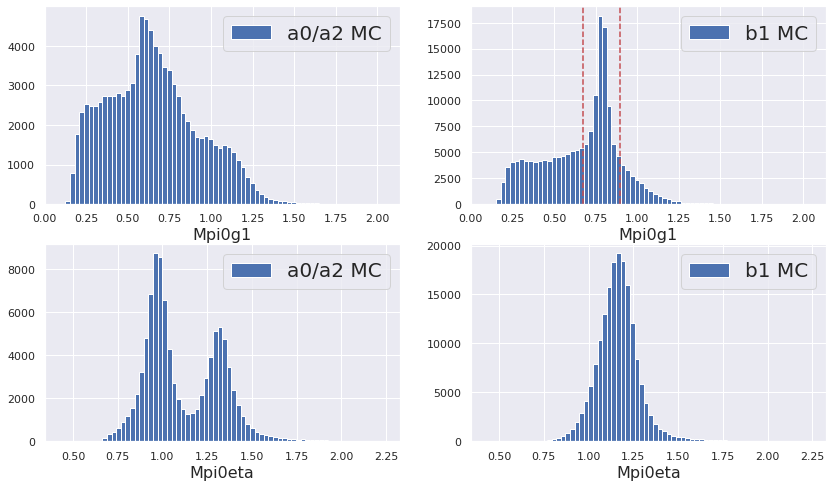

In [66]:
fig,ax=plt.subplots(2,2,figsize=(14,8))
ax=ax.flatten()

# Mpi0g
binedges=np.histogram(df.Mpi0g1,bins=70)[1]
df[(df.mcprocess==0)|(df.mcprocess==1)].Mpi0g1.hist(bins=binedges,ax=ax[0],label="a0/a2 MC")
df[df.mcprocess==2].Mpi0g1.hist(bins=binedges,ax=ax[1],label="b1 MC")

ax[0].set_xlabel("Mpi0g1",size=16)
ax[1].set_xlabel("Mpi0g1",size=16)
ax[0].legend(prop={"size":20})
ax[1].legend(prop={"size":20})
ax[1].axvline(uppThresh,c='r',linestyle="--")
ax[1].axvline(lowThresh,c='r',linestyle="--")

# Mpi0eta
binedges=np.histogram(df.Mpi0eta,bins=70)[1]
df[(df.mcprocess==0)|(df.mcprocess==1)].Mpi0eta.hist(bins=binedges,ax=ax[2],label="a0/a2 MC")
df[df.mcprocess==2].Mpi0eta.hist(bins=binedges,ax=ax[3],label="b1 MC")
ax[2].set_xlabel("Mpi0eta",size=16)
ax[3].set_xlabel("Mpi0eta",size=16)
ax[2].legend(prop={"size":20})
ax[3].legend(prop={"size":20})